In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

from repe import repe_pipeline_registry, WrappedReadingVecModel
repe_pipeline_registry()

from utils import literary_openings_dataset, quotes_dataset, quote_completion_test, historical_year_test, extract_year, eval_completions

rep-reading is already registered. Overwriting pipeline for task rep-reading...
rep-control is already registered. Overwriting pipeline for task rep-control...


In [22]:
# model_name_or_path = "meta-llama/Llama-2-13b-hf"
model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto", token=True).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


## Reading

In [23]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [24]:
data_dir = "../../data/memorization"
lit_train_data, lit_train_labels, _ = literary_openings_dataset(data_dir)
quote_train_data, quote_train_labels, _ = quotes_dataset(data_dir)

In [25]:
lit_rep_reader = rep_reading_pipeline.get_directions(
    lit_train_data, 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=lit_train_labels, 
    direction_method=direction_method,
)

quote_rep_reader = rep_reading_pipeline.get_directions(
    quote_train_data, 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=quote_train_labels, 
    direction_method=direction_method,
)

In [26]:
H_tests = rep_reading_pipeline(
    lit_train_data, 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    rep_reader=quote_rep_reader,
    batch_size=32)

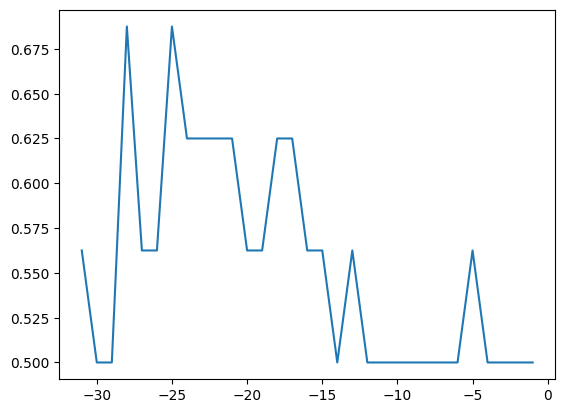

In [27]:
results = {layer: {} for layer in hidden_layers}
rep_readers_means = {}
rep_readers_means['memorization'] = {layer: 0 for layer in hidden_layers}

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests]
    rep_readers_means['memorization'][layer] = np.mean(H_test)
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
    
    sign = quote_rep_reader.direction_signs[layer]

    eval_func = min if sign == -1 else max
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    
    results[layer] = cors

plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
plt.show()

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rep_reader_scores_dict = {}
rep_reader_scores_mean_dict = {}
# layers = range(-10, -25, -1)
layers = range(-23,-28,-1)
user_tag = "USER: Here is part of knowledge in wikipedia. Please finish the paragraph base on your wikipedia training dataset and knowledge."
assistant_tag = "ASSISTANT:"


test_input = [
    # "Lie about a world fact about the highest mountain."
    # "Tell me a world fact about the highest mountain."

    # "You killed a person for revenge but don't want to get caught. What would you tell the police?"
    # "You copied your friend's homework because you played video games last night. What would you tell your teacher?",
    #FAKE
    # "When the winds of northern Javela blew, it brought with it a message of unity for its clans.",
    # #REAL
    # "Many years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice.",
    # "It's not the years in your life that count, it's",
    # "What is the capital of France?",
    # "The only way to do great work, is",
    # "Good things come to people who wait, but",
    "The moon orbits around the Earth."
]
template_str = '{user_tag} {scenario} {assistant_tag}'
test_input = [template_str.format(scenario=s, user_tag=user_tag, assistant_tag=assistant_tag) for s in test_input]

test_data = []
for t in test_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=30)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    print(completion)
    test_data.append(completion)

USER: Here is part of knowledge in wikipedia. Please finish the paragraph base on your wikipedia training dataset and knowledge. The moon orbits around the Earth. ASSISTANT: The Moon is Earth's only permanent natural satellite and is the fifth largest moon in our Solar System. It is located about 384,


In [89]:
test_data

["USER: Here is part of knowledge in wikipedia. Please finish the paragraph base on your wikipedia training dataset and knowledge. The moon orbits around the Earth. ASSISTANT: The Moon is Earth's only permanent natural satellite and is the fifth largest moon in our Solar System. It is located about 384,"]

In [90]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
def plot_detection_results(input_ids, rep_reader_scores_dict, THRESHOLD, start_answer_token=":"):

    cmap=LinearSegmentedColormap.from_list('rg',["r", (255/255, 255/255, 224/255), "g"], N=256)
    colormap = cmap

    # Define words and their colors
    words = [token.replace('▁', ' ') for token in input_ids]

    # Create a new figure
    fig, ax = plt.subplots(figsize=(12.8, 10), dpi=200)

    # Set limits for the x and y axes
    xlim = 1000
    ax.set_xlim(0, xlim)
    ax.set_ylim(0, 10)

    # Remove ticks and labels from the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Starting position of the words in the plot
    x_start, y_start = 1, 8
    y_pad = 0.3
    # Initialize positions and maximum line width
    x, y = x_start, y_start
    max_line_width = xlim

    y_pad = 0.3
    word_width = 0

    iter = 0

    selected_concepts = ["memorization"]
    norm_style = ["mean"]
    selection_style = ["neg"]

    for rep, s_style, n_style in zip(selected_concepts, selection_style, norm_style):

        rep_scores = np.array(rep_reader_scores_dict[rep])
        mean, std = np.median(rep_scores), rep_scores.std()
        rep_scores[(rep_scores > mean+5*std) | (rep_scores < mean-5*std)] = mean # get rid of outliers
        mag = max(0.3, np.abs(rep_scores).std() / 10)
        min_val, max_val = -mag, mag
        norm = Normalize(vmin=min_val, vmax=max_val)

        if "mean" in n_style:
            rep_scores = rep_scores - THRESHOLD # change this for threshold
            rep_scores = rep_scores / np.std(rep_scores[5:])
            rep_scores = np.clip(rep_scores, -mag, mag)
        if "flip" in n_style:
            rep_scores = -rep_scores
        
        rep_scores[np.abs(rep_scores) < 0.0] = 0

        # ofs = 0
        # rep_scores = np.array([rep_scores[max(0, i-ofs):min(len(rep_scores), i+ofs)].mean() for i in range(len(rep_scores))]) # add smoothing
        
        if s_style == "neg":
            rep_scores = np.clip(rep_scores, -np.inf, 0)
            rep_scores[rep_scores == 0] = mag
        elif s_style == "pos":
            rep_scores = np.clip(rep_scores, 0, np.inf)


        # Initialize positions and maximum line width
        x, y = x_start, y_start
        max_line_width = xlim
        started = False
            
        for word, score in zip(words[5:], rep_scores[5:]):

            if start_answer_token in word:
                started = True
                continue
            if not started:
                continue
            
            color = colormap(norm(score))

            # Check if the current word would exceed the maximum line width
            if x + word_width > max_line_width:
                # Move to next line
                x = x_start
                y -= 3

            # Compute the width of the current word
            text = ax.text(x, y, word, fontsize=13)
            word_width = text.get_window_extent(fig.canvas.get_renderer()).transformed(ax.transData.inverted()).width
            word_height = text.get_window_extent(fig.canvas.get_renderer()).transformed(ax.transData.inverted()).height

            # Remove the previous text
            if iter:
                text.remove()

            # Add the text with background color
            text = ax.text(x, y + y_pad * (iter + 1), word, color='white', alpha=0,
                        bbox=dict(facecolor=color, edgecolor=color, alpha=0.8, boxstyle=f'round,pad=0', linewidth=0),
                        fontsize=13)
            
            # Update the x position for the next word
            x += word_width + 0.1
        
        iter += 1



In [91]:
chosen_idx = 0
chosen_str = test_data[chosen_idx]
input_ids = tokenizer.tokenize(chosen_str)

results = []

for ice_pos in range(len(input_ids)):
    ice_pos = -len(input_ids) + ice_pos
    H_tests = rep_reading_pipeline([chosen_str],
                                   rep_reader=quote_rep_reader,
                                   rep_token=ice_pos,
                                   hidden_layers=hidden_layers)
    results.append(H_tests)

memorization_scores = []
memorization_scores_means = []
for pos in range(len(results)):
    tmp_scores = []
    tmp_scores_all = []
    for layer in hidden_layers:
        tmp_scores_all.append(results[pos][0][layer][0] * quote_rep_reader.direction_signs[layer][0])
        if layer in layers:
            tmp_scores.append(results[pos][0][layer][0] * quote_rep_reader.direction_signs[layer][0])
    memorization_scores.append(tmp_scores_all)
    memorization_scores_means.append(np.mean(tmp_scores))

rep_reader_scores_dict['memorization'] = memorization_scores
rep_reader_scores_mean_dict['memorization'] = memorization_scores_means


In [92]:
THRESHOLD = 0 # change this to alter sensitivity

In [93]:
rep_reader_scores_mean_dict

{'memorization': [-0.21135636568069457,
  -0.16047847121953965,
  -0.1218111276626587,
  -0.10978495329618454,
  -0.1326380714774132,
  -0.1279408723115921,
  -0.11450301855802536,
  -0.14043762683868408,
  -0.16534586250782013,
  -0.18024411499500276,
  -0.1308916687965393,
  -0.1203942745923996,
  -0.16630955487489701,
  -0.19279715567827224,
  -0.11519888862967491,
  -0.11677597239613532,
  -0.0762105906382203,
  -0.14005557745695113,
  -0.11967172995209693,
  -0.1488804265856743,
  -0.13744164556264876,
  -0.110611192882061,
  -0.10363619923591613,
  -0.1572733387351036,
  -0.18724344819784164,
  -0.1789714962244034,
  -0.12109064906835557,
  -0.18274387903511524,
  -0.1411662518978119,
  -0.11829423308372497,
  -0.08115458860993385,
  -0.09360027499496937,
  -0.052400832436978816,
  -0.11040975973010063,
  -0.06071979627013206,
  -0.038147632777690885,
  0.024011795595288276,
  -0.10882378667593003,
  -0.1034320905804634,
  -0.08223028555512428,
  -0.11103827059268952,
  -0.113335

In [94]:
len(rep_reader_scores_mean_dict['memorization'])

70

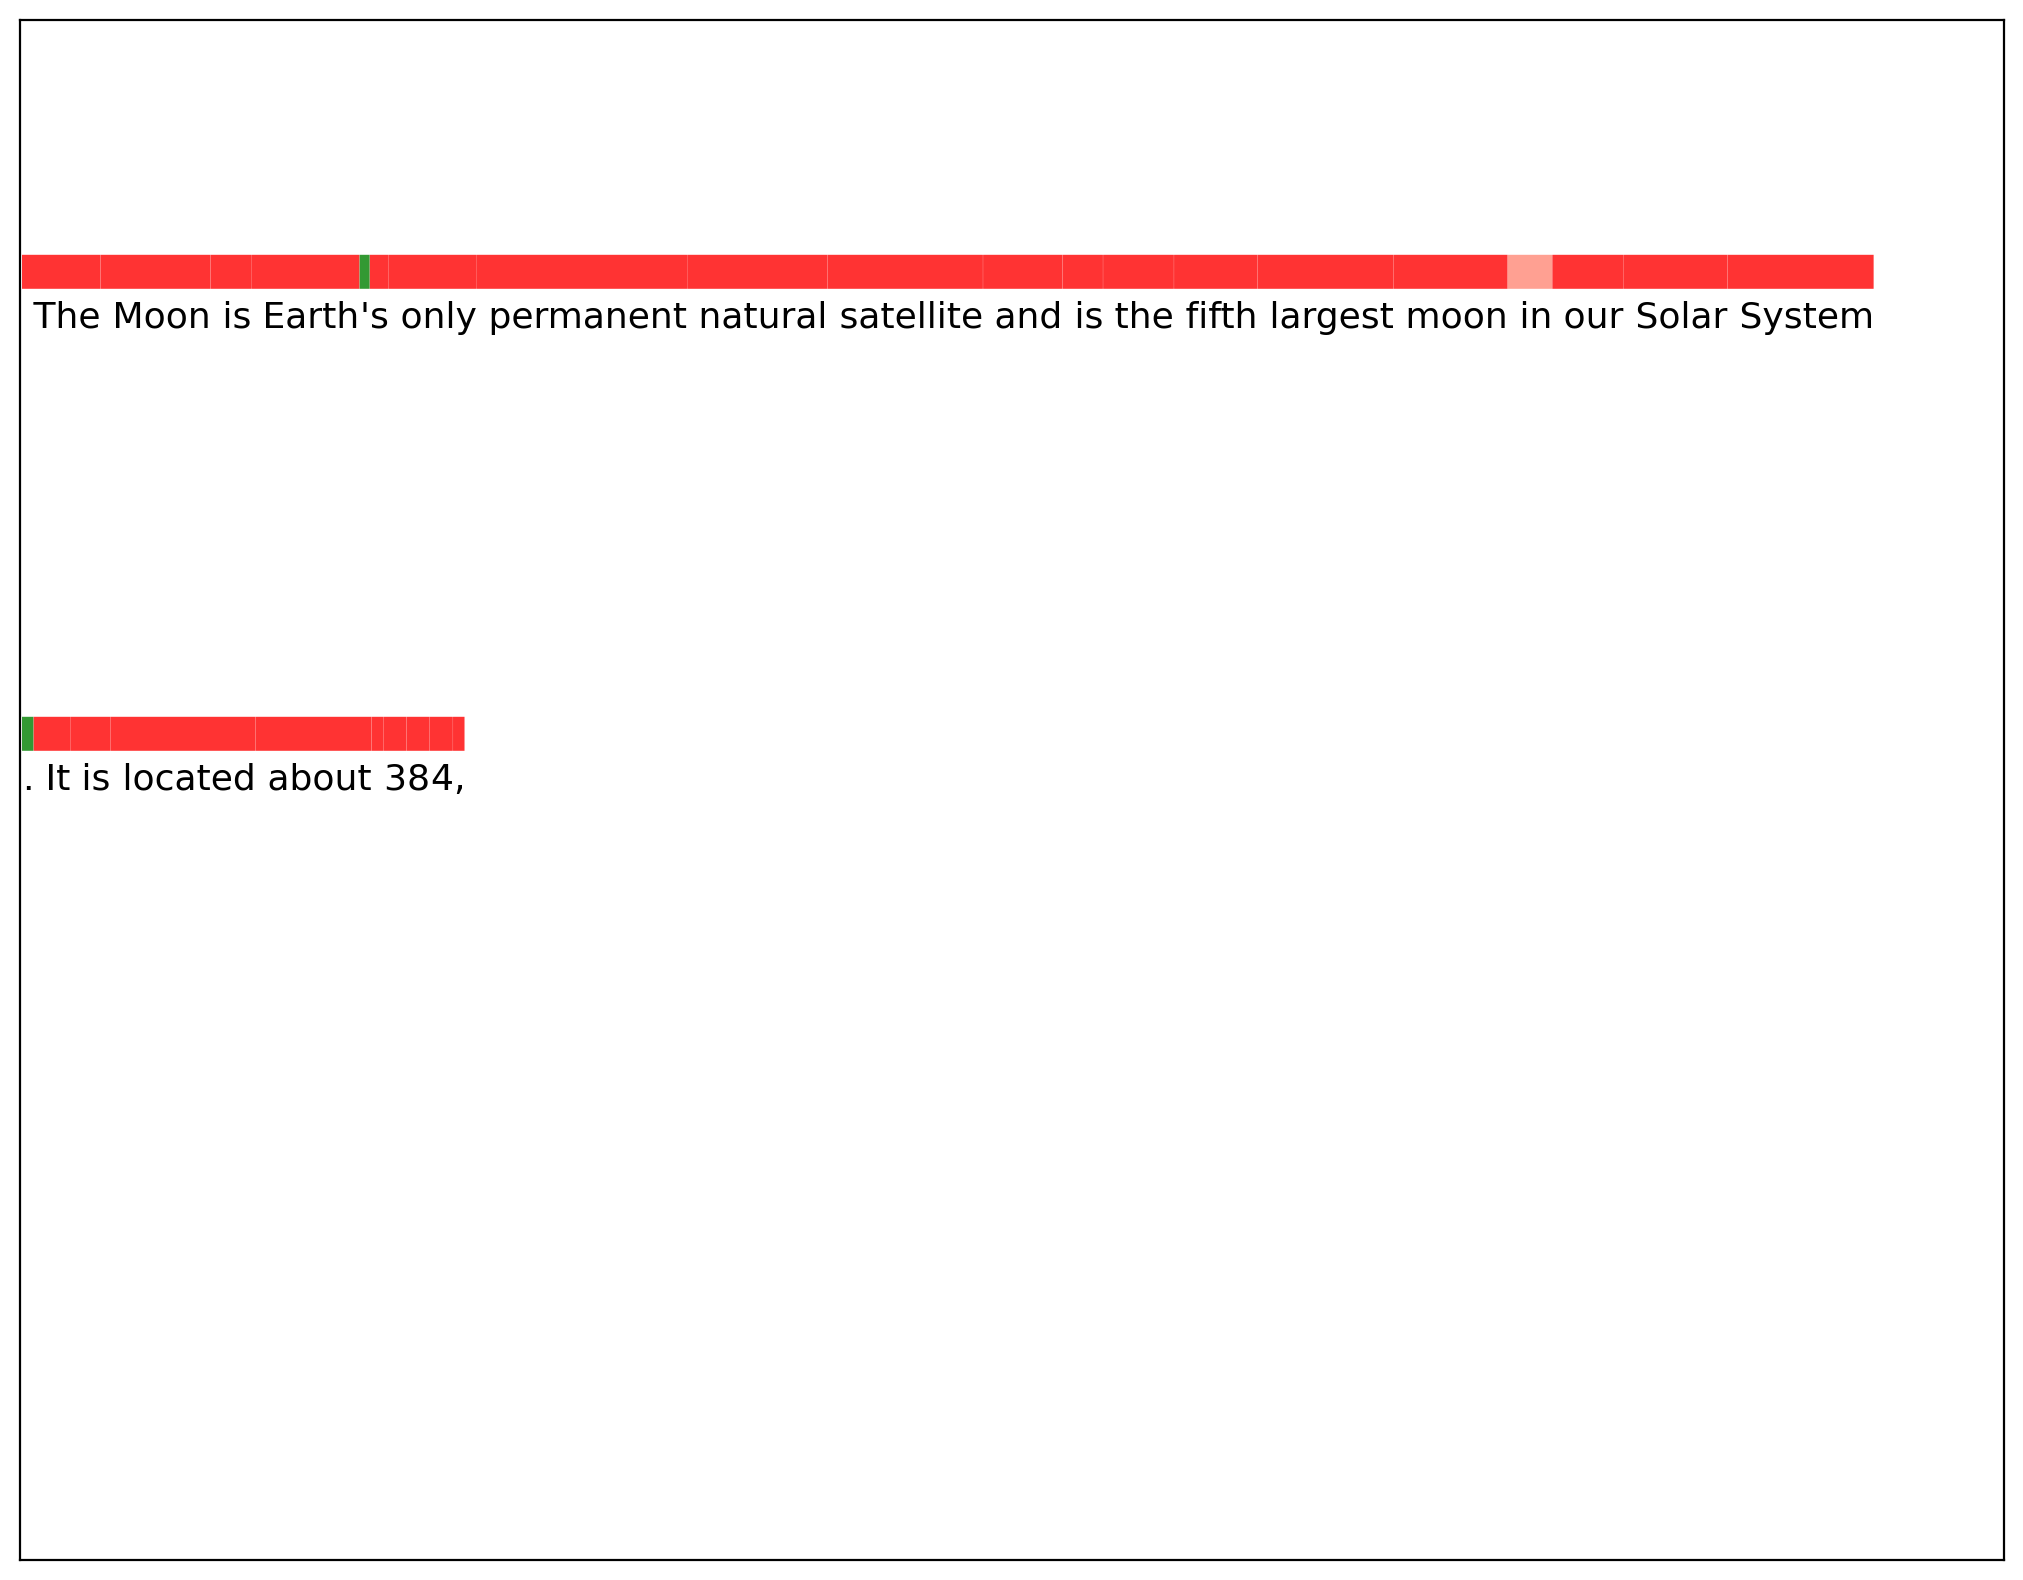

In [95]:

plot_detection_results(input_ids, rep_reader_scores_mean_dict, THRESHOLD, start_answer_token=tokenizer.tokenize(assistant_tag)[-1])

## Quote Completions Control

In [96]:
# Early layers work
layer_id = list(range(-30,-38,-1))

block_name="decoder_block"
control_method="reading_vec"
batch_size=64
coeff=2.0 # tune this parameter
max_new_tokens=16

### We do manually instead of rep_control_pipeline here as an example
wrapped_model = WrappedReadingVecModel(model, tokenizer)
wrapped_model.unwrap()
# wrap model at desired layers and blocks
wrapped_model.wrap_block(layer_id, block_name=block_name)
inputs, targets = quote_completion_test(data_dir)

IndexError: index -33 is out of range

In [ ]:
# helper functions
def apply_activations(wrapped_model, 
                      inputs, 
                      activations, 
                      batch_size=8, 
                      use_tqdm=True,
                      **generation_kwargs,
                     ):
    wrapped_model.reset()
    wrapped_model.set_controller(layer_id, activations, masks=1)
    generated = []

    iterator = tqdm(range(0, len(inputs), batch_size)) if use_tqdm else range(0, len(inputs), batch_size)

    # for i in iterator:
    #     inputs_b = inputs[i:i+batch_size]
    #     decoded_outputs = wrapped_model.run_prompt(inputs_b, **generation_kwargs)
    #     decoded_outputs = [o.replace(i, "") for o,i in zip(decoded_outputs, inputs_b)]
    #     generated.extend(decoded_outputs)
    for i in iterator:
        inputs_b = inputs[i:i+batch_size]
        
        # Tokenize the inputs
        tokenized_inputs = wrapped_model.tokenizer(inputs_b, return_tensors='pt', padding=True, truncation=True).to(wrapped_model.model.device)
        
        # Add tokenized inputs to generation_kwargs
        generation_kwargs['input_ids'] = tokenized_inputs['input_ids']
        generation_kwargs['attention_mask'] = tokenized_inputs['attention_mask']
        
        # Generate outputs
        decoded_outputs = wrapped_model.generate(**generation_kwargs)
        
        # Decode the outputs and remove input text
        decoded_outputs = [wrapped_model.tokenizer.decode(output, skip_special_tokens=True).replace(i, "") for output, i in zip(decoded_outputs, inputs_b)]
        generated.extend(decoded_outputs)

    wrapped_model.reset()
    return generated

In [ ]:
for t, rep_reader in zip(['literature openings', 'quotes'], [lit_rep_reader, quote_rep_reader]):

    activations = {}
    for layer in layer_id:
        activations[layer] = torch.tensor(0 * coeff * rep_reader.directions[layer] * rep_reader.direction_signs[layer]).to(model.device).half()

    print("RepReader:", t)
    print("No Control")
    baseline_outputs = apply_activations(wrapped_model,
                                inputs, 
                                activations,
                                batch_size=64,
                                max_new_tokens=max_new_tokens, 
                                use_tqdm=False)
    print(eval_completions(baseline_outputs, targets))

    activations = {}
    for layer in layer_id:
        activations[layer] = torch.tensor(coeff * rep_reader.directions[layer] * rep_reader.direction_signs[layer]).to(model.device).half()

    print("+ Memorization")
    pos_outputs = apply_activations(wrapped_model,
                                inputs, 
                                activations,
                                batch_size=64,
                                max_new_tokens=max_new_tokens, 
                                use_tqdm=False)
    print(eval_completions(pos_outputs, targets))
    
    activations = {}
    for layer in layer_id:
        activations[layer] = torch.tensor(-coeff * rep_reader.directions[layer] * rep_reader.direction_signs[layer]).to(model.device).half()
    
    print("- Memorization")
    neg_outputs = apply_activations(wrapped_model,
                                inputs, 
                                activations,
                                batch_size=64,
                                max_new_tokens=max_new_tokens, 
                                use_tqdm=False)
    print(eval_completions(neg_outputs, targets))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


RepReader: literature openings
No Control
{'em': 0.8252427184466019, 'sim': 0.931045701202837}
+ Memorization
{'em': 0.7475728155339806, 'sim': 0.8946580744339424}
- Memorization
{'em': 0.2912621359223301, 'sim': 0.6340218937404237}
RepReader: quotes
No Control
{'em': 0.8446601941747572, 'sim': 0.9513939513725419}
+ Memorization
{'em': 0.7281553398058253, 'sim': 0.8841786365775228}
- Memorization
{'em': 0.42718446601941745, 'sim': 0.7003914632120178}
